# Making inference with pretrained UNet and B-UNet models

Define functions and set up environment

In [1]:
import torch
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from models.unet3d.model import BUNet3D,UNet3D

import os 
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchviz import make_dot
from colossalai.utils import load_checkpoint
from colossalai.initialize import launch,initialize
import colossalai
from colossalai.trainer import Trainer, hooks
import h5py as h5
from dataloaders import get_synth_dhcp_dataloader, get_synth_hcp_dataloader

In [2]:
def load_model(model_path:str):
    model = torch.load(model_path)
    model.eval()
    return model

def load_image(mode :str = 'h5', 
               paths = ['/home/viscent/hdd/dhcp/dhcp_lores/preprocessed_h5/sub-CC00582XX14.h5'],
               dataset = 'dhcp',
               data_dir = '/home/viscent/hdd/dhcp/dhcp_lores/',):
    if mode == 'h5':
        with h5.File(paths[0],'r') as f:
            image = f['image_t1'][...].astype(np.float32)
            target = f['gt_t1'][...].astype(np.float32)
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'sitk':
        image = sitk.ReadImage(paths[0])
        target = sitk.ReadImage(paths[1])
        image = sitk.GetArrayFromImage(image)
        target = sitk.GetArrayFromImage(target)
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'npy':
        image = np.load(paths[0])
        target = np.load(paths[1])
        image_tensor = torch.from_numpy(image).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'dataloader':
        if dataset == 'dhcp':
            dataloaders, val_loader = get_synth_dhcp_dataloader(data_dir=data_dir,
                                                                batch_size=1,
                                                                num_samples=50,
                                                                input_modalities=["t1"],
                                                                output_modalities=["t1"],
                                                                output_dir=data_dir,
                                                                n_splits=5,
                                                                augmentation=False,
                                                                down_factor=5,)
        elif dataset == 'hcp':
            dataloaders, val_loader = get_synth_hcp_dataloader(data_dir=data_dir,
                                                                batch_size=1,
                                                                num_samples=50,
                                                                input_modalities=["t1"],
                                                                output_modalities=["t1"],
                                                                output_dir=data_dir,
                                                                n_splits=5,
                                                                augmentation=False,
                                                                down_factor=5,)
        image_tensor, target_tensor = next(iter(val_loader))
        image_tensor = image_tensor.cuda()
        target_tensor = target_tensor.cuda()
        return image_tensor,target_tensor

def plot_latent(model):
    encoder_weights = next(model.encoders[-1].parameters())
    encoder_weights = encoder_weights.cpu().detach().numpy()
    encoder_weights= np.expand_dims(encoder_weights,axis=1)
    encoder_weights = np.repeat(encoder_weights, 128, axis=1)
    if hasattr(model, 'enc_mu'):
        fig,(ax1,ax2) = plt.subplots(1,2)
        im1 = ax1.imshow(encoder_weights)
        ax1.set_title("encoder weights")
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im1, cax=cax, orientation="vertical")

        latent_weights = next(model.mu.parameters())
        latent_weights = latent_weights.cpu().detach().numpy()
        latent_weights = np.repeat(latent_weights, 128, axis=1)

        im2 = ax2.imshow(encoder_weights)
        ax2.set_title("latent weights")
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im2, cax=cax, orientation="vertical")
        fig.show()
    else:
        fig = plt.imshow(encoder_weights)
        plt.title("encoder weights")
        plt.colorbar()
        plt.show()
    # plt.savefig(OUTPUT_PREFIX+"_encoder_weights.png")

def infer(model,image_tensor):
    output_tensor = model(image_tensor)
    return output_tensor

def get_metrics(output_tensor,target_tensor, model, mu_q = None, logvar_q = None):
    im = target_tensor
    im_hat = output_tensor
    mse = torch.nn.MSELoss()(im, im_hat)
    mse.backward()
    print('mse:', mse.cpu().detach().numpy())
    if hasattr(model, 'enc_mu'):
        mu_p, logvar_p = model.enc_mu,model.enc_logvar
        # kl = 0.5 * ((logvar_q-logvar_p) + (mu_p-mu_q) / logvar_q.exp() * (mu_p-mu_q) - 1 - logvar_p.exp() * logvar_q.exp()).sum()
        kl = 0.5 * (logvar_p.exp() + mu_p**2 - 1 - logvar_p).sum()
        # kl = 0.5 * ((logvar_q-logvar_p) - 3 + (mu_p - mu_q) / logvar_q.exp() * (mu_p-mu_q) + torch.trace)
        # kl = torch.sum(kl)
        FE_simple = mse + 0.00025 * kl
        print('kl:', kl.cpu().detach().numpy())
        print('Free energy:', FE_simple.cpu().detach().numpy())

def plot_output(image_tensor,output_tensor,target_tensor):
    image_tensor = image_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    output_tensor = output_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    target_tensor = target_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    im1 = ax1.imshow(image_tensor[image_tensor.shape[0]//2,:,:],cmap='gray')
    ax1.set_title("image")


    im2 = ax2.imshow(output_tensor[output_tensor.shape[0]//2,:,:],cmap='gray')
    ax2.set_title("output")
    
    
    im3 = ax3.imshow(target_tensor[target_tensor.shape[0]//2,:,:],cmap='gray')
    ax2.set_title("target")
    fig.show()



In [3]:
model_vae_dhcp = load_model('/media/hdd/viscent/create-models/20220607/vae_dhcp/299.pth')
model_vae_hcp = load_model('/media/hdd/viscent/create-models/20220607/vae_hcp/299.pth')
model_unet_dhcp = load_model('/media/hdd/viscent/create-models/20220607/unet_dhcp/299.pth')
model_unet_hcp = load_model('/media/hdd/viscent/create-models/20220607/unet_hcp/299.pth')

mu_vae_dhcp = model_vae_dhcp.enc_mu
logvar_vae_dhcp = model_vae_dhcp.enc_logvar
mu_vae_hcp = model_vae_hcp.enc_mu
logvar_vae_hcp = model_vae_hcp.enc_logvar

In [4]:
optim_vae_dhcp = torch.optim.Adam(
    model_vae_dhcp.parameters(),
    lr=0.001,
    betas=(0.9, 0.99)
)
optim_vae_hcp = torch.optim.Adam(
    model_vae_hcp.parameters(),
    lr=0.001,
    betas=(0.9, 0.99)
)

criteria = nn.MSELoss()

## Results on dHCP

In [5]:
image_tensor,target_tensor = load_image()
image_tensor_dHCP = image_tensor.clone()
target_tensor_dHCP = target_tensor.clone()

### VAE-dHCP

/tmp/ipykernel_1199273/4193361468.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


mse: 0.044561896
kl: 0.0060230643
Free energy: 0.0445634


/tmp/ipykernel_1199273/4193361468.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


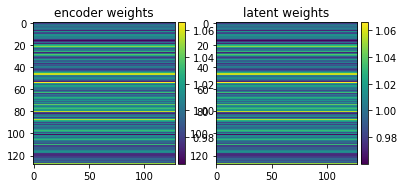

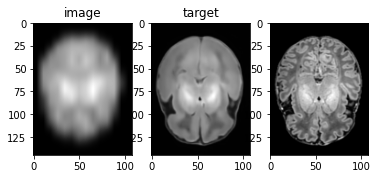

In [6]:
plot_latent(model_vae_dhcp)
output_tensor = infer(model_vae_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_dhcp, mu_q= mu_vae_dhcp, logvar_q= logvar_vae_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### VAE-HCP

/tmp/ipykernel_1199273/4193361468.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


mse: 0.21460855
kl: 2.5417798
Free energy: 0.215244


/tmp/ipykernel_1199273/4193361468.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


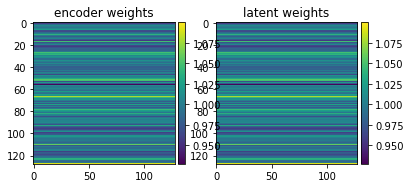

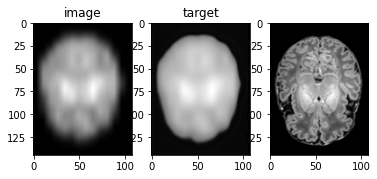

In [7]:
plot_latent(model_vae_hcp)
output_tensor = infer(model_vae_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_hcp, mu_q= mu_vae_hcp, logvar_q= logvar_vae_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-dHCP

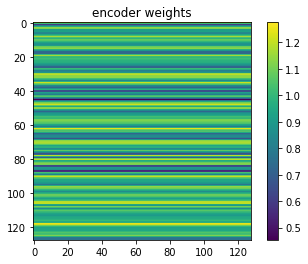

mse: 0.0374123


/tmp/ipykernel_1199273/4193361468.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


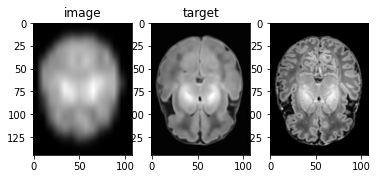

In [8]:
plot_latent(model_unet_dhcp)
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-HCP

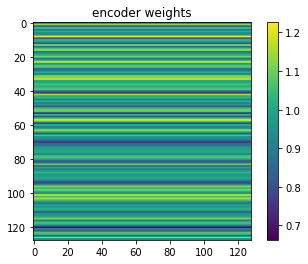

mse: 0.18996984


/tmp/ipykernel_1199273/4193361468.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


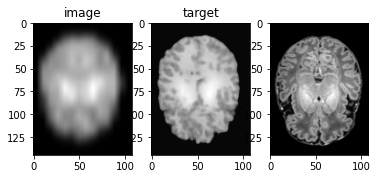

In [9]:
plot_latent(model_unet_hcp)
output_tensor = infer(model_unet_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

## Results on HCP

In [10]:
image_tensor,target_tensor = load_image(mode='h5',paths=['/media/hdd/HCP_1200/preprocessed_h5/100206.h5'])
image_tensor_HCP = image_tensor.clone()
target_tensor_HCP = target_tensor.clone()

### VAE-dHCP

/tmp/ipykernel_1199273/4193361468.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


mse: 0.16693738
kl: 0.0060230643
Free energy: 0.16693889


/tmp/ipykernel_1199273/4193361468.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


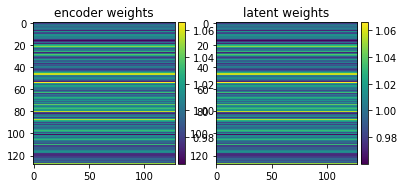

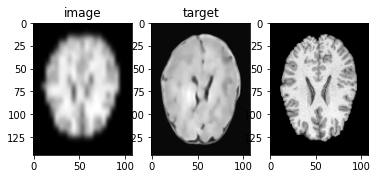

In [11]:
plot_latent(model_vae_dhcp)
output_tensor = infer(model_vae_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_dhcp, mu_q= mu_vae_dhcp, logvar_q= logvar_vae_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### VAE-HCP

/tmp/ipykernel_1199273/4193361468.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


mse: 0.026350316
kl: 0.0010825098
Free energy: 0.026350586


/tmp/ipykernel_1199273/4193361468.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


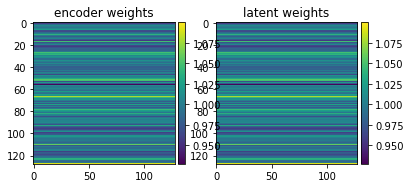

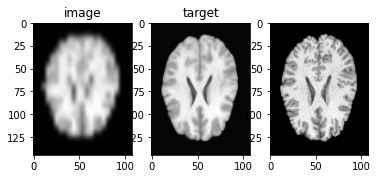

In [12]:
plot_latent(model_vae_hcp)
output_tensor = infer(model_vae_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_hcp, mu_q= mu_vae_hcp, logvar_q= logvar_vae_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-dHCP

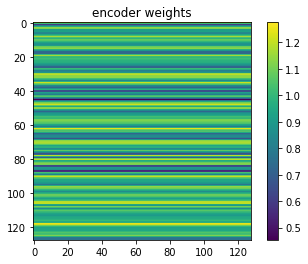

mse: 0.17149962


/tmp/ipykernel_1199273/4193361468.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


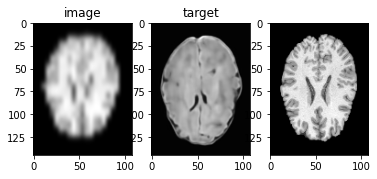

In [13]:
plot_latent(model_unet_dhcp)
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-HCP

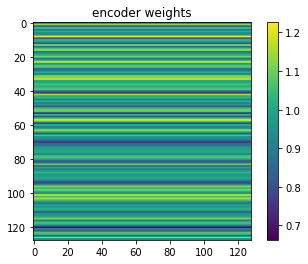

mse: 0.021776242


/tmp/ipykernel_1199273/4193361468.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


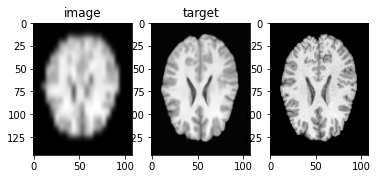

In [14]:
plot_latent(model_unet_hcp)
output_tensor = infer(model_unet_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

In [15]:
model_dbg = load_model('/home/viscent/hdd/viscent/SR-UNet/experiments/output_unet_dhcp_dbg/0/checkpoints/1.pth')

In [16]:
enc_mu = model_dbg.enc_mu.cpu().detach().numpy()
model_dbg(image_tensor_dHCP)
enc_mu_dhcp = model_dbg.enc_mu.cpu().detach().numpy()
model_dbg(image_tensor_HCP)
enc_mu_hcp = model_dbg.enc_mu.cpu().detach().numpy()

In [17]:
print((enc_mu_dhcp-enc_mu_hcp).mean())
print((enc_mu_dhcp-enc_mu).mean())
print((enc_mu_hcp-enc_mu).mean())

-0.002258077
-0.0014161424
0.0008419338
